In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg

import seaborn as sns
from sklearn import datasets, linear_model
from tqdm.notebook import tqdm
import random
import math
import json

## Generate data

In [77]:
! python create_toybrains.py -d -n 100

Generative parameter        |        States 
------------------------------------------------------------
brain_vol-radminor         [20 21 22 23 24]
brain_vol-radmajor         [26 27 28 29 30]
brain_thick                [1 2 3 4]
brain_int                  [210 200 190 180 170]
border_int                 ['mediumslateblue' 'slateblue' 'darkslateblue' 'darkblue']
vent_thick                 [1 2 3 4]
shape-top_curv             [ 3  4  5  6  7  8  9 10 11]
shape-top_int              ['indianred' 'salmon' 'lightsalmon' 'palegoldenrod' 'lightgreen'
 'darkgreen']
shape-top_vol-rad          [2 3 4 5]
shape-midr_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midr_int             ['indianred' 'salmon' 'lightsalmon' 'palegoldenrod' 'lightgreen'
 'darkgreen']
shape-midr_vol-rad         [2 3 4 5]
shape-midl_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midl_int             ['indianred' 'salmon' 'lightsalmon' 'palegoldenrod' 'lightgreen'
 'darkgreen']
shape-midl_vol-rad         [2 3 4 5]


## Visualize the data

In [78]:
df = pd.read_csv(glob("toybrains/toybrains_n*.csv")[0]).set_index('subjectID')
# sort dataframe cols by column name
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _gen_brain_vol-radmajor   100 non-null    float64
 1   _gen_brain_vol-radminor   100 non-null    float64
 2   _gen_shape-botl_vol-rad   100 non-null    float64
 3   _gen_shape-botr_vol-rad   100 non-null    float64
 4   _gen_shape-midl_vol-rad   100 non-null    float64
 5   _gen_shape-midr_vol-rad   100 non-null    float64
 6   _gen_shape-top_vol-rad    100 non-null    float64
 7   cov_age                   100 non-null    float64
 8   cov_sex                   100 non-null    object 
 9   cov_site                  100 non-null    object 
 10  gen_border_int            100 non-null    object 
 11  gen_brain_int             100 non-null    float64
 12  gen_brain_thick           100 non-null    float64
 13  gen_brain_vol             100 non-null    float64
 14  gen_shape-b

In [108]:
from  matplotlib.ticker import FuncFormatter
from matplotlib.colors import is_color_like
from colordict import ColorDict, rgb_to_hex

def plot_col_dists(df, title=''):
    
    # convert column to appropriate dtype and then decide the plottype
    df_copy = df.reindex(sorted(df.columns), axis=1).copy()
    cols = df_copy.columns 

    plottypes = {}
    for col in cols:
        if df_copy[col].nunique()==2:
            plottypes.update({col:'pie'})
        elif df_copy[col].dtype.name == 'object' or isinstance(df_copy.loc[0,col], str):
            plottypes.update({col:'bar'})
        elif 'float' in df_copy[col].dtype.name:
            # round the floats to 2 decimal
            df_copy[col] = df[col].round(1)
            # use hist plot if there are more than 10 states  
            if df_copy[col].nunique()<10:
                plottypes.update({col:'bar'})
            else:
                plottypes.update({col:'hist'})
            # if all values are int then covert col to int dtype
            if df_copy[col].dropna().apply(float.is_integer).all():
                df_copy[col] = df_copy[col].astype(int)
            
    # re-sort dataframe cols by dtypes
    cols = df_copy.dtypes.sort_values().index 
    # decide the number of rows and columns in the plot
    subplot_ncols = 5 if len(cols)>=5 else len(cols)
    subplot_nrows = len(cols)//subplot_ncols
    subplot_overflows = len(cols)%subplot_ncols
    if subplot_overflows!=0: subplot_nrows+=1
    # create subplots set attributes
    f,axes = plt.subplots(subplot_nrows, subplot_ncols, 
                          figsize=(4*subplot_ncols,3*subplot_nrows))
    if title: f.suptitle(title, fontsize=16)
    f.supylabel("Count")
    
    for i, ax in enumerate(axes.ravel()):
        col = cols[i]
        plottype = plottypes[col]
        # print('[D]',col, plottypes[col])
        if i >= subplot_ncols*(len(cols)//subplot_ncols) + subplot_overflows:
            ax.axis('off')
        elif plottype == 'bar':
            # if the columns represent colors then use the same colors for the bar plot
            if isinstance(df_copy.loc[0,col], str) and is_color_like(df_copy.loc[0,col]):
                colormap = ColorDict()
                colors = [rgb_to_hex(colormap[c]) for c in df_copy[col].unique().tolist()]

                sns.countplot(data=df_copy, x=col, ax=ax, palette=colors)
            else:
                sns.countplot(data=df_copy, x=col, ax=ax)
            # format the xtick labels 
            if 'int' in df_copy[col].dtype.name:
                ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
            elif isinstance(df_copy.loc[0,col], str):
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        elif plottype == 'hist':
            sns.histplot(data=df_copy, x=col, ax=ax)
        elif plottype == 'pie':
            cnt = df_copy[col].value_counts().sort_index()
            ax.pie(cnt, labels=cnt.index,
                    colors=sns.color_palette('pastel'), autopct='%.0f%%')
            
        ax.set_title(col)
        ax.set_xlabel(None)

    plt.tight_layout()

### Distribution of covariates

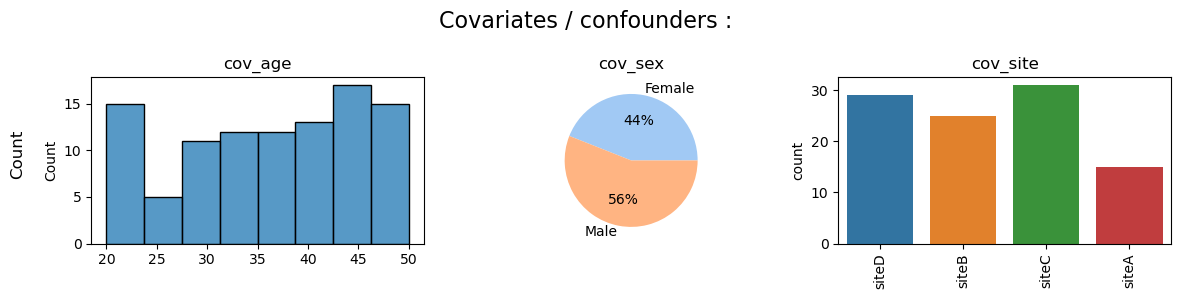

In [109]:
# get all column names starting with 'gen_'
plot_col_dists(df.filter(regex='^cov_'), title="Covariates / confounders :")
plt.show()

#### Distribution of labels

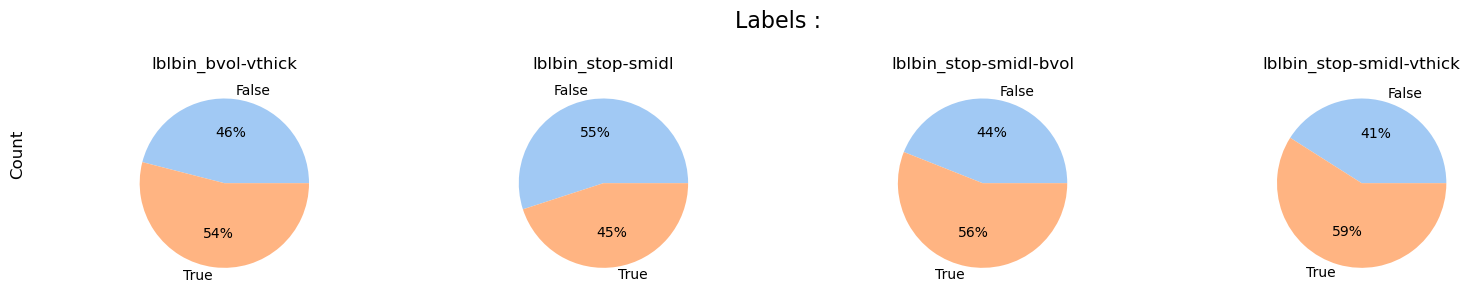

In [110]:
# get all column names starting with 'gen_'
plot_col_dists(df.filter(regex='^lbl'), title="Labels :")
plt.show()

### Distribution of generative params

TODO: the color names should be sorted in the bar plot's X axis

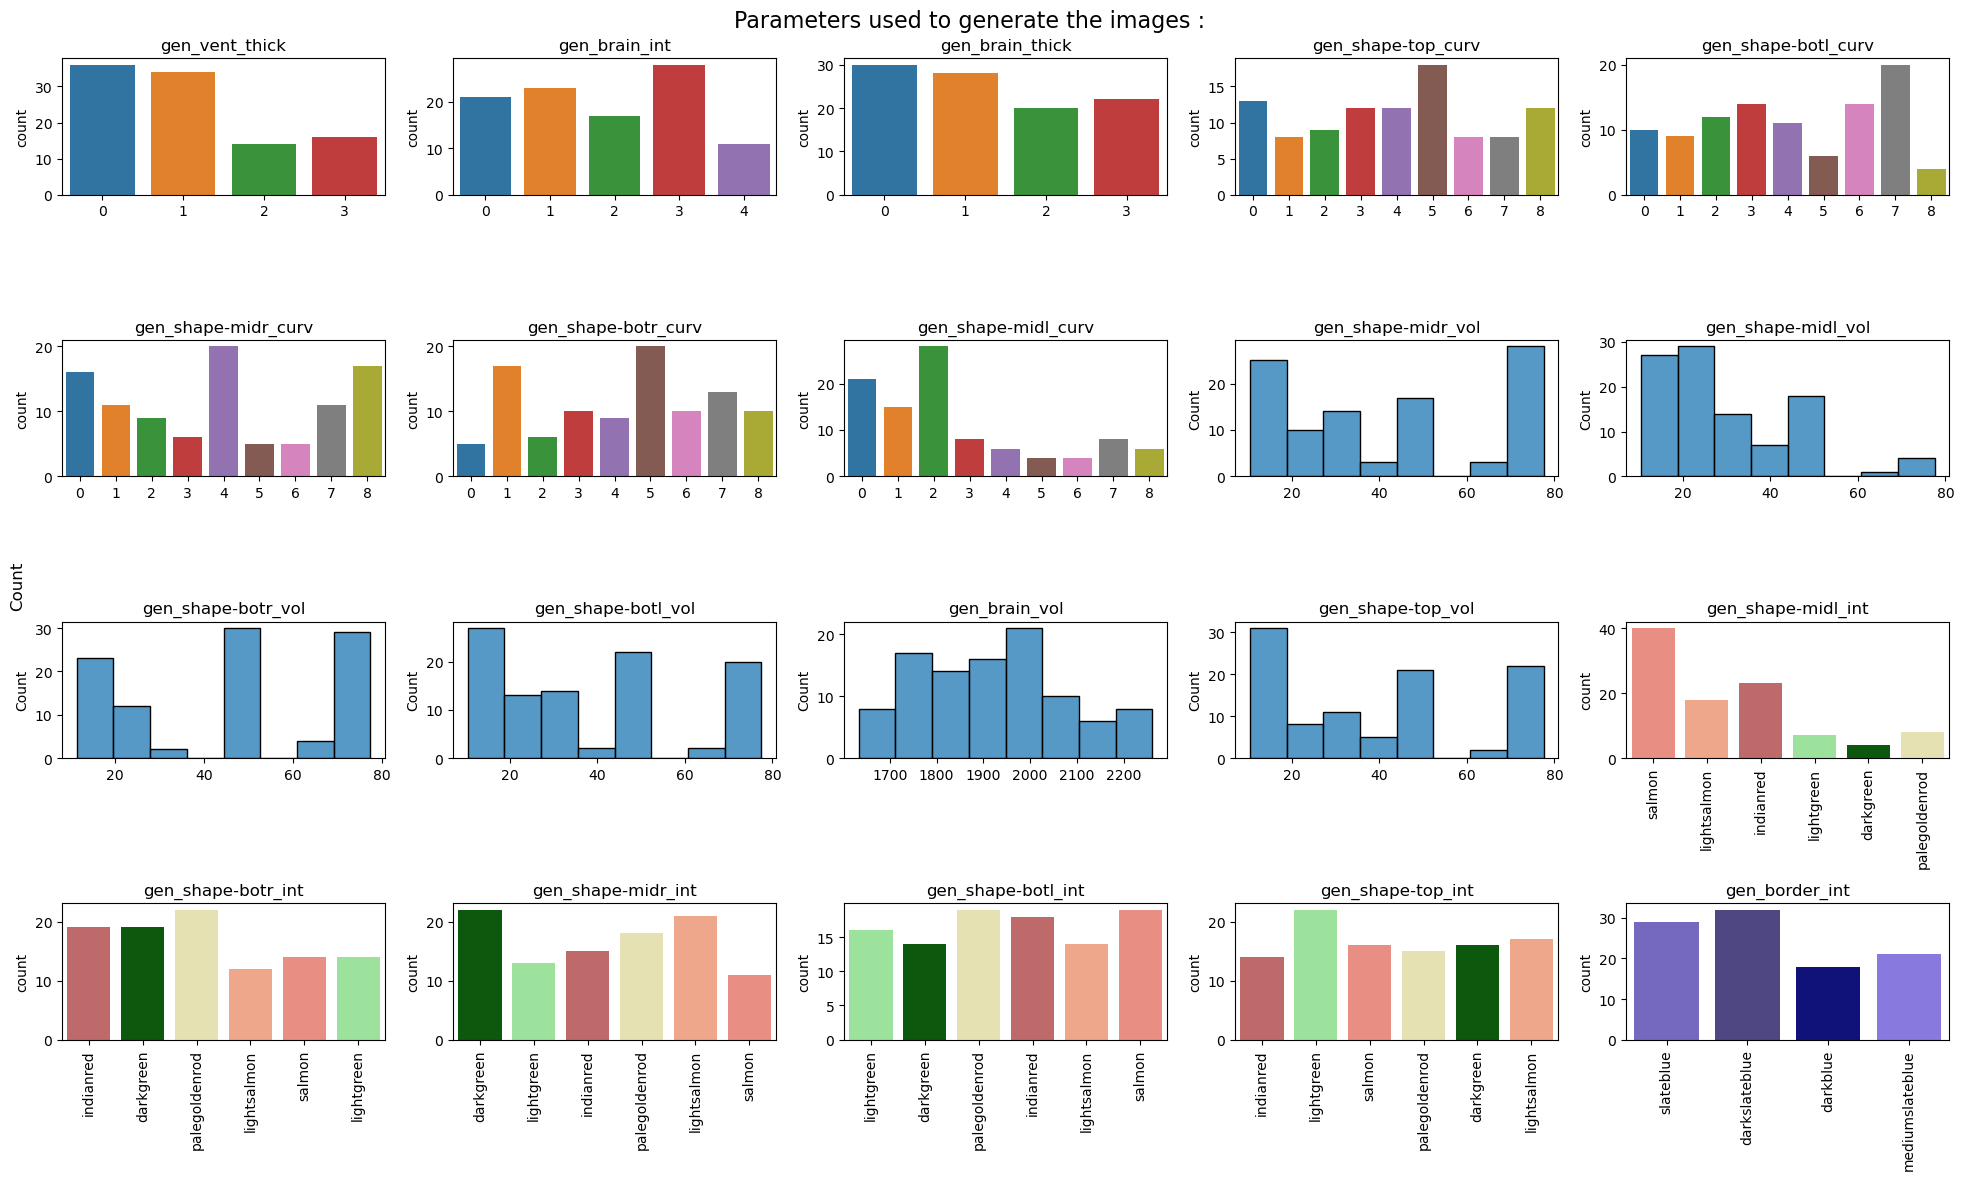

In [111]:
# get all column names starting with 'gen_'
plot_col_dists(df.filter(regex='^gen_'), title="Parameters used to generate the images :")
plt.show()

### Plot distribution across cov values and label groups
TODO: use hue to show different label states for the same distribution

In [ ]:
sns.countplot(data=df, x="gen_brain_vol-radmajor", hue="cov_sex")
plt.show()
sns.countplot(data=df, x="gen_brain_int", hue="cov_site")
plt.show()
sns.histplot(data=df, x="cov_age", hue="gen_vent_thick")
plt.show()

### Images

In [ ]:
def show_images(img_files, n_rows=1):
    assert isinstance(img_files[0], (str,np.ndarray, np.generic)), "img_files \
should either me a string path to the image files or numpy arrays"   
    n_cols = 10
    f, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows), 
                           sharex=True, sharey=True)
    # f.suptitle("Toy brains dataset:")
    axes = axes.ravel()

    for i, img in enumerate(img_files):
        if i<len(axes):
            if isinstance(img, str):
                img = mpimg.imread(img)
            ax = axes[i]
            ax.imshow(img)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
img_files = sorted(glob("shapes/images/*.jpg"))

show_images(img_files=img_files, n_rows=1)

#### All generative variables
1. 'brain_vol' # total volume of the brain ranging between 1633 to 2261 [(S/2-12)*(S/2-6) to (S/2-8)*(S/2-2)]
2. 'brain_thick' # the thickness of the blue border around the brain ranging between 1 to 4
3. 'brain_int', # the intensity or brightness of the brain region ranging between 'greyness0' to 'greyness4'

#### Confounds
2. ~`age ~ brain_vol & vent_thick` such that `up(age) -> up(vent_thick)` `up(age) -> down(brain_vol)`~
3. ~`sex ~ brain_vol` such that `(sex=Male) -> up(brain_vol)`~
4. ~`site ~ outline_color & brain_int`~
4. Find citations for (2) and (3)
5. add lesions? 
6. ~add a shape {triangle, square, pentagon, hexagon, ..} at top bottom right and left~
7. check the color gradients make sense

#### Labels
1. purely based on 4 shapes (combinations that are linear and non-linear)
2. partially based on confounder + partially shapes : see the idea from MDN
3. purely based on confounder pathway
4. Create a brain_mask and save it as a label

In [ ]:
from PIL import Image, ImageDraw
S=200
# Create a new image with a black background
img = Image.new("RGB", (S, S), color="black")

# Draw two arcs at the center of the image, facing opposite to each other and touching at the center
draw = ImageDraw.Draw(img)
x_off, y_off= 0,0
xy_r = (S*.2, S*.2, S*.5, S*.5)
xy_l = (S*.5, S*.2, S*.8, S*.5)
print(xy_r, xy_l)
draw.arc(xy_r, start=300, end=100,   fill="red",  width=8)
draw.arc(xy_l, start=-300, end=-100, fill="blue", width=8)

# Show the image
img